In [22]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [23]:
result = llm.invoke("What is investment?")
print(result.content)

Investment is the act of committing money or capital to an endeavor with the expectation of obtaining an additional income or profit.  This income can be in the form of:

* **Capital appreciation:**  The asset increases in value over time.  For example, buying a stock that increases in price.
* **Interest or dividends:**  Regular payments received from the asset. For example, interest from a bond or dividends from a stock.
* **Rental income:** Income generated from renting out a property.

Investments can be made in a wide variety of assets, including:

* **Stocks:** Ownership shares in a company.
* **Bonds:** Loans to a company or government.
* **Real estate:** Land and buildings.
* **Mutual funds:** Pooled investments in a variety of assets.
* **Exchange-traded funds (ETFs):** Similar to mutual funds, but traded on an exchange.
* **Commodities:** Raw materials like gold, oil, or agricultural products.
* **Private equity:** Investments in privately held companies.
* **Cryptocurrencies

In [24]:
%pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


#### Retriever

In [25]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs=[WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,
    chunk_overlap=0,
)

docs_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=docs_splits,
    embedding=embeddings,
    persist_directory="generative_rag_db",
    collection_name="rag-chroma",
    
)

retriever = vectorstore.as_retriever()


## Rag Chain 

In [26]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

print(f"--PROMPT--{prompt}")

def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

rag_chain = prompt | llm | StrOutputParser()

--PROMPT--input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [27]:
question="tell me about the agent memory"
generation=rag_chain.invoke({"context":docs,"question":question})
print(generation)

LLM-powered autonomous agents utilize two types of memory: short-term memory,  which leverages in-context learning within the model's limited context window, and long-term memory, which uses an external vector store for storing and retrieving information over extended periods.  The long-term memory often employs approximate nearest neighbors algorithms for fast retrieval.


### grader

In [28]:
from langchain_core.prompts import  ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score:str = Field(
        description="Documents are relevant to the question . 'yes' or 'no' "
    )

In [29]:

structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [30]:
question="tell me about the agent memory"
docs = retriever.get_relevant_documents(question)

doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"document":doc_txt,"question":question}))

binary_score='yes'


### Rewrite the Query

In [31]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

## functions

In [32]:
def retrieve(state):
    """
    Retrieve the most relevant documents from the vectorstore.

    Args:
        state (dict): The current graph state

    Returns:

    """
    print("---Retrive---")
    question = state["question"]
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents,"question": question}

In [33]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")

    question= state["question"]
    documents = state["documents"]

    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": doc.page_content}
                                        )
        grade= score.binary_score
        if grade=="yes":
            print("---GRADE: DOCUMENT IS RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT IS NOT RELEVANT---")
            web_search="Yes"
            continue
    return {"documents": filtered_docs, "question": question,"web_search": web_search}

In [45]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [34]:
def generate(state):
    """
    Generates a response based on the retrieved documents and the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates the answer key with the generated response
    """
    
    print("---GENERATING ANSWER---")
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [35]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")

    question = state["question"]
    documents= state["documents"]

    better_question= question_rewriter.invoke(
        {"question": question,
        #   "documents": documents
         }
    )
    return {"documents": documents, "question": better_question}

### Tavily for webbase Fetching

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search = TavilySearchResults(k=3)

In [37]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")

    question = state["question"]
    documents = state["documents"]

    docs = web_search.invoke({"query": question})

    web_results="\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    documents.append(web_results)
    return {"documents": documents, "question": question}

## State

In [38]:
from langgraph.graph import START,END, StateGraph

In [39]:
from typing import List

from typing_extensions import TypedDict

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: The question we are trying to answer.
        generation: The generated answer.
        web_search: The result of the web search.
        documents: The documents retrieved from the vector store.
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

workflow = StateGraph(State)

In [ ]:
workflow.add_node("retrieve_main",retrieve)
workflow.add_node("grade_document",grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("transform_query",transform_query)
workflow.add_node("web_search_node",web_search)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [58]:
# Build graph
workflow.add_edge(START, "retrieve_main")

workflow.add_edge("retrieve_main", "grade_document")

workflow.add_conditional_edges("grade_document", decide_to_generate, {"transform_query": "transform_query","generate": "generate",}),

workflow.add_edge("transform_query", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [59]:
app = workflow.compile()

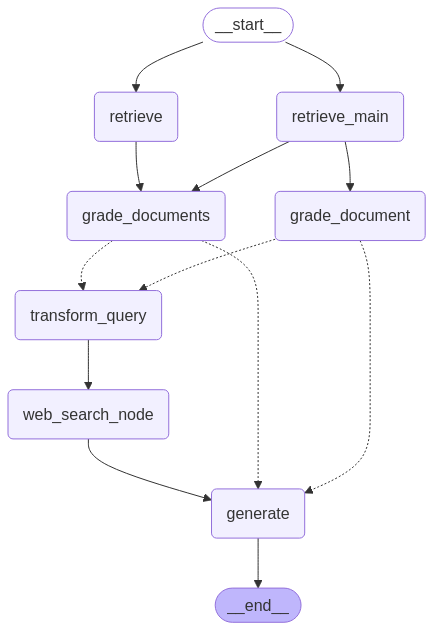

In [60]:
app